In [8]:
from ultralytics import YOLO
model = YOLO("..\\training_code\\runs\\classify\\yolo11m-cls_v3_aug2\\weights\\best.pt")

read_dir="..\\trainingDatav3\\val"
# read_dir = "./pngVersion/"1
output_dir="./"


image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competition\1\final_testset\..\trainingDatav3\val\var\10003_var.png: 224x224 var 1.00, yok 0.00, 21.8ms
Speed: 3.2ms preprocess, 21.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
True label: var, Predicted: var

image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competition\1\final_testset\..\trainingDatav3\val\var\100170_var.png: 224x224 var 0.97, yok 0.03, 21.9ms
Speed: 3.4ms preprocess, 21.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
True label: var, Predicted: var

image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competition\1\final_testset\..\trainingDatav3\val\var\10039_var.png: 224x224 var 1.00, yok 0.00, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
True label: var, Predicted: var

image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competit

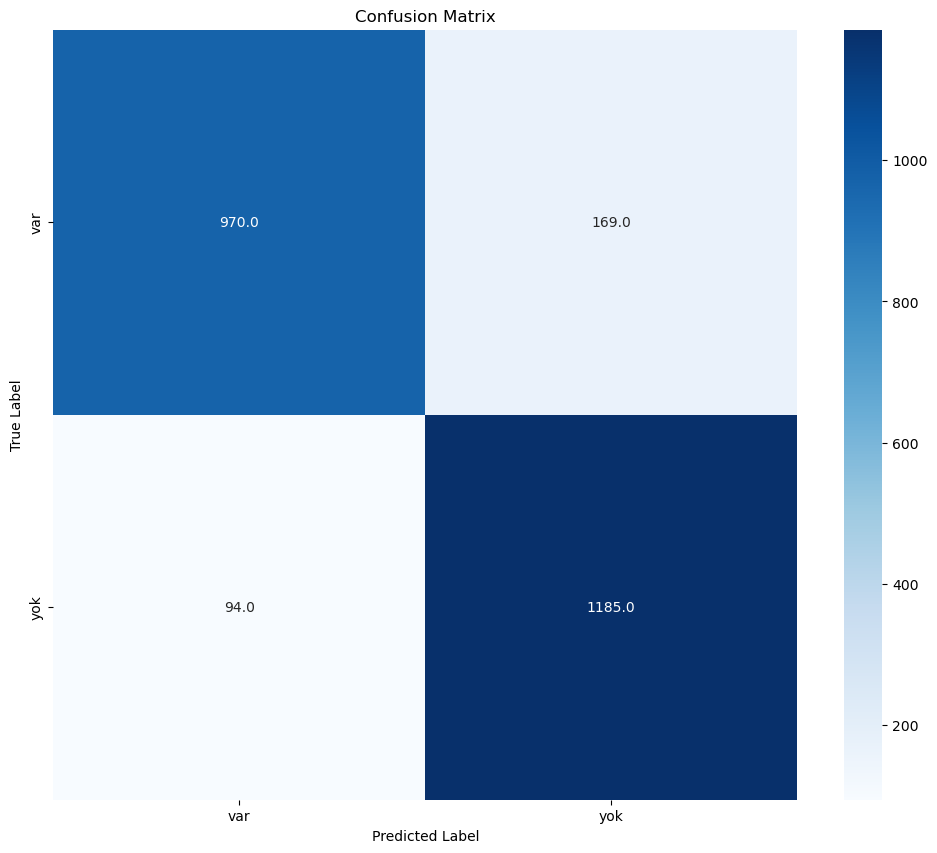

In [ ]:
from ultralytics import YOLO
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import shutil
from pathlib import Path
import os


T = 0
F = 0

# Lists to store true and predicted labels for the confusion matrix
all_true_labels = []
all_pred_labels = []
class_names = list(model.names.values()) # Get class names from the main model

# Usage
for path in read_images(read_dir):
    if "MR" in str(path):
        continue

    label = path.stem.split("_")[-1]
    all_true_labels.append(label)

    result = model.predict(source=path, save=False)
    result = result[0]
    pred = result.probs.top1
    predlabel = result.names[pred]
    conf = result.probs.top1conf
    newResult = None

    final_pred_label = ""
    if newResult is None:
        if(conf < 0.76):  # Threshold for low confidence
            final_pred_label="yok"
        else:
            final_pred_label = result.names[pred]

        if final_pred_label.lower() == label.lower():
            T += 1
        else:
            F += 1
        print(f"True label: {label}, Predicted: {final_pred_label}")
    else:
        pred = newResult.probs.top1
        final_pred_label = newResult.names[pred]
        if final_pred_label.lower() == label.lower():
            T += 1
        else:
            F += 1
        print(f"True label: {label}, Predicted: {final_pred_label}")
        print(f"First hit: {result.names[result.probs.top1]}, Second hit: {final_pred_label}, First hit conf {result.probs.top1conf}, Second hit conf: {newResult.probs.top1conf}")

    all_pred_labels.append(final_pred_label)

print(f"True: {T}, False: {F}")
print(f"Accuracy: {T / (T + F) * 100:.2f}%")

# --- New Code for Confusion Matrix ---

# Ensure all class names are present for matrix calculation
all_labels = sorted(list(set(all_true_labels + all_pred_labels)))

# Calculate the confusion matrix
cm = confusion_matrix(all_true_labels, all_pred_labels, labels=all_labels)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create the plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the plot
plt.savefig('confusion_matrix_non_hybrid.png', dpi=300)
print("\nConfusion matrix saved to confusion_matrix.png")

In [1]:
# Define read_images function if not already defined
def read_images(directory):
    """Generator function to read images from directory structure"""
    from pathlib import Path
    
    directory = Path(directory)
    if not directory.exists():
        print(f"Directory {directory} does not exist")
        return
    
    # Look for images in subdirectories
    for subdir in directory.iterdir():
        if subdir.is_dir():
            for img_file in subdir.glob("*.png"):
                yield img_file
            for img_file in subdir.glob("*.jpg"):
                yield img_file
            for img_file in subdir.glob("*.jpeg"):
                yield img_file


Confusion matrix saved to confusion_matrix.png


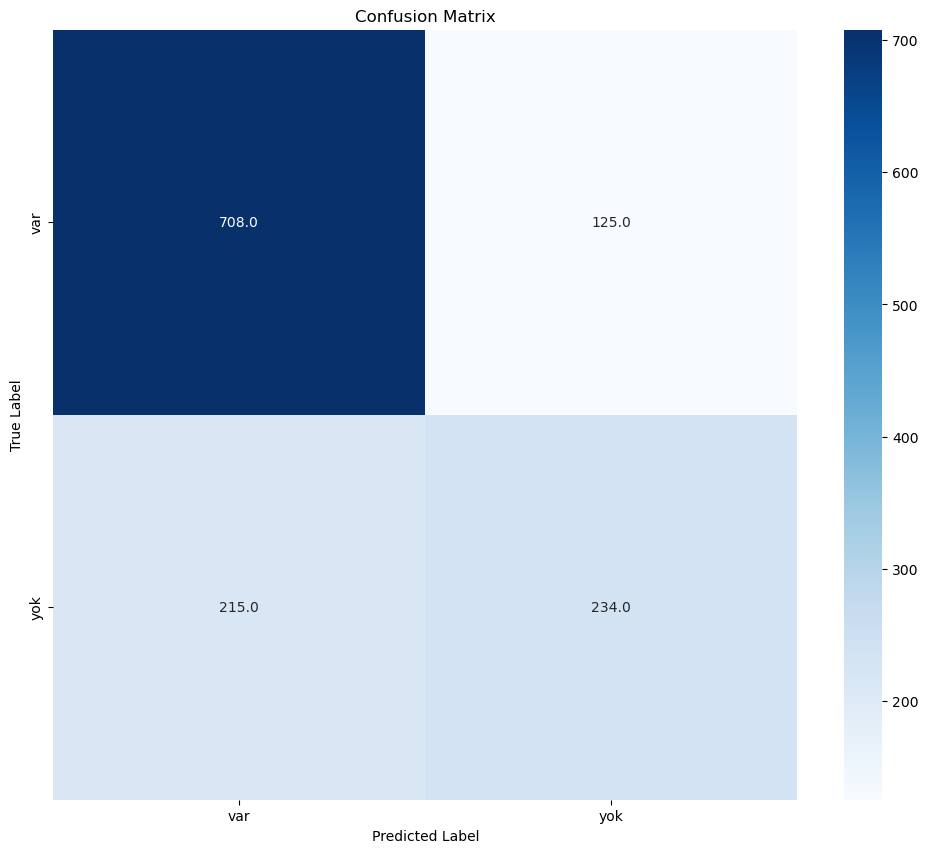

In [4]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt=".1f", cmap='Blues',
            xticklabels=all_labels, yticklabels=all_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Save the plot
plt.savefig('confusion_matrix.png', dpi=300)
print("\nConfusion matrix saved to confusion_matrix.png")

In [ ]:
# ===== THRESHOLD OPTIMIZATION FOR MAXIMUM ACCURACY =====
import numpy as np
print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION ANALYSIS")
print("="*60)

# Collect all prediction data with confidence scores
prediction_data = []
true_labels_for_threshold = []
confidence_scores = []

print("Collecting prediction data with confidence scores...")

for path in read_images(read_dir):
    if "MR" in str(path):
        continue

    label = path.stem.split("_")[-1]
    true_labels_for_threshold.append(label)

    result = model.predict(source=path, save=False)
    result = result[0]
    
    # Get top predictions and their confidence scores
    probs = result.probs.data.cpu().numpy()  # All class probabilities
    top1_idx = result.probs.top1
    top1_conf = result.probs.top1conf.item()
    top1_label = result.names[top1_idx]
    
    # Store prediction data
    prediction_data.append({
        'true_label': label,
        'top1_label': top1_label,
        'top1_conf': top1_conf,
        'all_probs': probs,
        'class_names': result.names
    })
    
    confidence_scores.append(top1_conf)

print(f"Collected {len(prediction_data)} predictions")

# Test different threshold values
threshold_range = np.arange(0.1, 1.0, 0.05)  # From 10% to 95% confidence
threshold_results = []

print(f"\nTesting {len(threshold_range)} different threshold values...")

for threshold in threshold_range:
    correct_predictions = 0
    total_predictions = 0
    yok_predictions = 0  # Predictions assigned to "yok" due to low confidence
    
    for data in prediction_data:
        total_predictions += 1
        
        if data['top1_conf'] >= threshold:
            # Accept original prediction if confidence >= threshold
            final_prediction = data['top1_label']
        else:
            # Assign to "yok" class if confidence < threshold
            final_prediction = "yok"
            yok_predictions += 1
        
        # Check if final prediction is correct
        if final_prediction.lower() == data['true_label'].lower():
            correct_predictions += 1
    
    # Calculate metrics (now all predictions are made, no rejections)
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    coverage = 1.0  # Always 100% coverage since we make prediction for all samples
    
    threshold_results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'coverage': coverage,
        'correct': correct_predictions,
        'total': total_predictions,
        'yok_assigned': yok_predictions,
        'original_predictions': total_predictions - yok_predictions
    })

# Convert to DataFrame for easier analysis
import pandas as pd
results_df = pd.DataFrame(threshold_results)

# Find optimal threshold (you can adjust the criteria)
# Since coverage is always 100%, we focus on maximum accuracy
best_accuracy_idx = results_df['accuracy'].idxmax()
best_accuracy_threshold = results_df.iloc[best_accuracy_idx]

# Option 2: Find threshold that minimizes "yok" assignments while maintaining good accuracy
# This balances between accuracy and keeping original model predictions
results_df['yok_ratio'] = results_df['yok_assigned'] / results_df['total']
results_df['score'] = results_df['accuracy'] * (1 - results_df['yok_ratio'])  # Penalize high "yok" assignments
best_tradeoff_idx = results_df['score'].idxmax()
best_tradeoff_threshold = results_df.iloc[best_tradeoff_idx]

# Option 3: Maximum accuracy with minimal "yok" assignments (less than 20% assigned to "yok")
low_yok_df = results_df[results_df['yok_ratio'] <= 0.2]
if len(low_yok_df) > 0:
    best_low_yok_idx = low_yok_df['accuracy'].idxmax()
    best_low_yok_threshold = low_yok_df.iloc[best_low_yok_idx]
else:
    best_low_yok_threshold = None

print("\n" + "="*50)
print("THRESHOLD OPTIMIZATION RESULTS")
print("(Low confidence predictions assigned to 'yok' class)")
print("="*50)

print(f"\n1. MAXIMUM ACCURACY:")
print(f"   Threshold: {best_accuracy_threshold['threshold']:.2f}")
print(f"   Accuracy: {best_accuracy_threshold['accuracy']:.4f} ({best_accuracy_threshold['accuracy']*100:.2f}%)")
print(f"   Original predictions: {best_accuracy_threshold['original_predictions']}")
print(f"   Assigned to 'yok': {best_accuracy_threshold['yok_assigned']}")
print(f"   Yok assignment ratio: {best_accuracy_threshold['yok_assigned']/best_accuracy_threshold['total']*100:.1f}%")
print(f"   Correct predictions: {best_accuracy_threshold['correct']}/{best_accuracy_threshold['total']}")

print(f"\n2. BEST ACCURACY WITH MINIMAL 'YOK' ASSIGNMENTS:")
print(f"   Threshold: {best_tradeoff_threshold['threshold']:.2f}")
print(f"   Accuracy: {best_tradeoff_threshold['accuracy']:.4f} ({best_tradeoff_threshold['accuracy']*100:.2f}%)")
print(f"   Original predictions: {best_tradeoff_threshold['original_predictions']}")
print(f"   Assigned to 'yok': {best_tradeoff_threshold['yok_assigned']}")
print(f"   Yok assignment ratio: {best_tradeoff_threshold['yok_assigned']/best_tradeoff_threshold['total']*100:.1f}%")
print(f"   Score (Acc × (1-YokRatio)): {best_tradeoff_threshold['score']:.4f}")
print(f"   Correct predictions: {best_tradeoff_threshold['correct']}/{best_tradeoff_threshold['total']}")

if best_low_yok_threshold is not None:
    print(f"\n3. BEST ACCURACY WITH ≤20% 'YOK' ASSIGNMENTS:")
    print(f"   Threshold: {best_low_yok_threshold['threshold']:.2f}")
    print(f"   Accuracy: {best_low_yok_threshold['accuracy']:.4f} ({best_low_yok_threshold['accuracy']*100:.2f}%)")
    print(f"   Original predictions: {best_low_yok_threshold['original_predictions']}")
    print(f"   Assigned to 'yok': {best_low_yok_threshold['yok_assigned']}")
    print(f"   Yok assignment ratio: {best_low_yok_threshold['yok_assigned']/best_low_yok_threshold['total']*100:.1f}%")
    print(f"   Correct predictions: {best_low_yok_threshold['correct']}/{best_low_yok_threshold['total']}")
else:
    print(f"\n3. No threshold found with ≤20% 'yok' assignments")

# Original accuracy (no threshold)
original_accuracy = results_df.iloc[0]['accuracy'] if results_df.iloc[0]['threshold'] <= 0.1 else None
if original_accuracy:
    print(f"\nORIGINAL ACCURACY (no threshold): {original_accuracy:.4f} ({original_accuracy*100:.2f}%)")

print(f"\nConfidence score statistics:")
print(f"Mean confidence: {np.mean(confidence_scores):.4f}")
print(f"Std confidence: {np.std(confidence_scores):.4f}")
print(f"Min confidence: {np.min(confidence_scores):.4f}")
print(f"Max confidence: {np.max(confidence_scores):.4f}")


THRESHOLD OPTIMIZATION ANALYSIS

image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competition\1\final_testset\..\trainingDatav3\val\var\10003_var.png: 224x224 var 1.00, yok 0.00, 21.8ms
Speed: 3.3ms preprocess, 21.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competition\1\final_testset\..\trainingDatav3\val\var\10003_var.png: 224x224 var 1.00, yok 0.00, 21.8ms
Speed: 3.3ms preprocess, 21.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competition\1\final_testset\..\trainingDatav3\val\var\100170_var.png: 224x224 var 0.97, yok 0.03, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 c:\Users\alt_user\Documents\GitHub\Teknofest25_AI_in_Medicine_Competition\1\final_testset\..\trainingDatav3\val\var\100170_var.png: 2

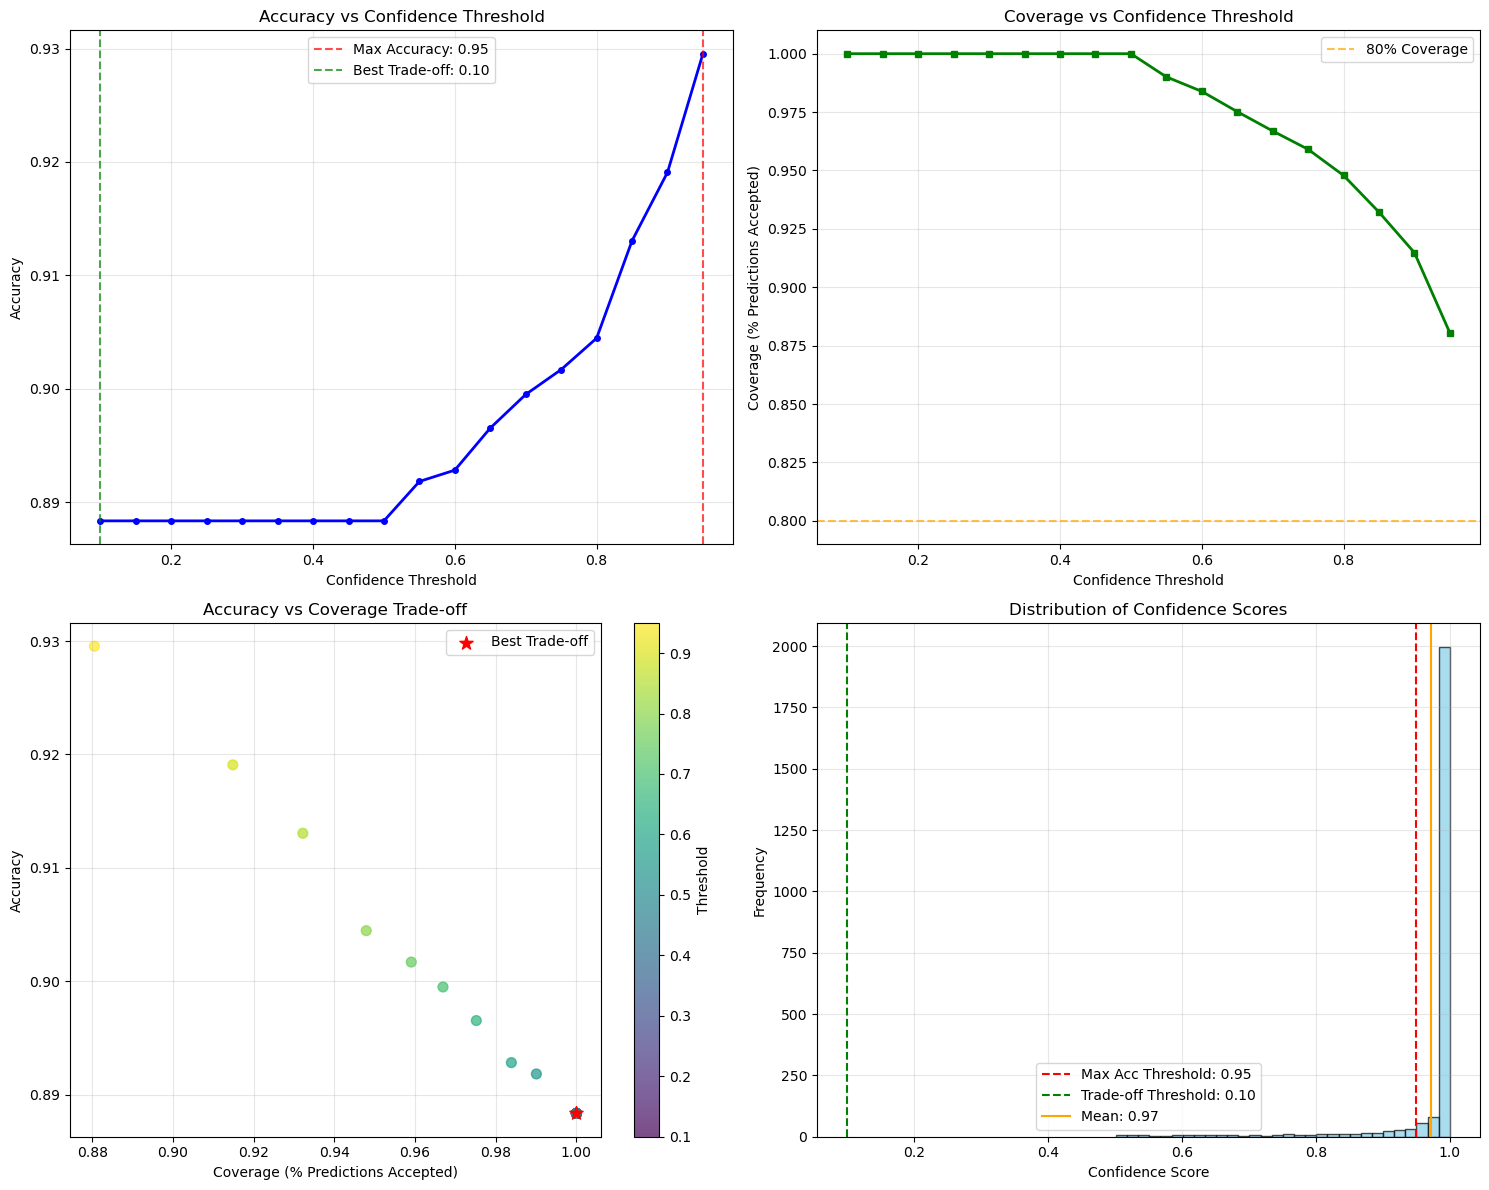

Threshold optimization plots saved to 'threshold_optimization_analysis.png'


In [ ]:
# ===== VISUALIZATION OF THRESHOLD ANALYSIS =====
import matplotlib.pyplot as plt
# Create visualization plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Accuracy vs Threshold
ax1.plot(results_df['threshold'], results_df['accuracy'], 'b-', linewidth=2, marker='o', markersize=4)
ax1.axvline(best_accuracy_threshold['threshold'], color='red', linestyle='--', alpha=0.7, 
            label=f'Max Accuracy: {best_accuracy_threshold["threshold"]:.2f}')
ax1.axvline(best_tradeoff_threshold['threshold'], color='green', linestyle='--', alpha=0.7,
            label=f'Best Trade-off: {best_tradeoff_threshold["threshold"]:.2f}')
ax1.set_xlabel('Confidence Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Confidence Threshold\n(Low confidence → "yok" predictions)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Yok Assignment Ratio vs Threshold
ax2.plot(results_df['threshold'], results_df['yok_ratio']*100, 'r-', linewidth=2, marker='s', markersize=4)
ax2.axhline(20, color='orange', linestyle='--', alpha=0.7, label='20% Yok Assignment')
ax2.set_xlabel('Confidence Threshold')
ax2.set_ylabel('% Predictions Assigned to "yok"')
ax2.set_title('Yok Assignment Ratio vs Confidence Threshold')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Accuracy vs Yok Assignment Ratio (Trade-off)
ax3.scatter(results_df['yok_ratio']*100, results_df['accuracy'], c=results_df['threshold'], 
           cmap='viridis', s=50, alpha=0.7)
ax3.scatter(best_tradeoff_threshold['yok_ratio']*100, best_tradeoff_threshold['accuracy'], 
           color='red', s=100, marker='*', label='Best Trade-off', zorder=5)
ax3.set_xlabel('% Predictions Assigned to "yok"')
ax3.set_ylabel('Accuracy')
ax3.set_title('Accuracy vs Yok Assignment Trade-off')
ax3.grid(True, alpha=0.3)
ax3.legend()
cbar = plt.colorbar(ax3.collections[0], ax=ax3)
cbar.set_label('Threshold')

# Plot 4: Confidence Score Distribution with threshold lines
ax4.hist(confidence_scores, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax4.axvline(best_accuracy_threshold['threshold'], color='red', linestyle='--', 
            label=f'Max Acc Threshold: {best_accuracy_threshold["threshold"]:.2f}')
ax4.axvline(best_tradeoff_threshold['threshold'], color='green', linestyle='--',
            label=f'Trade-off Threshold: {best_tradeoff_threshold["threshold"]:.2f}')
ax4.axvline(np.mean(confidence_scores), color='orange', linestyle='-', 
            label=f'Mean: {np.mean(confidence_scores):.2f}')
ax4.set_xlabel('Confidence Score')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Confidence Scores\n(Below threshold → "yok" predictions)')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.savefig('threshold_optimization_yok_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Threshold optimization plots saved to 'threshold_optimization_yok_analysis.png'")

In [ ]:
# ===== APPLY OPTIMAL THRESHOLD FOR FINAL PREDICTIONS =====

# Choose your preferred threshold strategy
STRATEGY = "tradeoff"  # Options: "max_accuracy", "tradeoff", "low_yok"

if STRATEGY == "max_accuracy":
    optimal_threshold = best_accuracy_threshold['threshold']
    print(f"Using maximum accuracy strategy with threshold: {optimal_threshold:.2f}")
elif STRATEGY == "tradeoff":
    optimal_threshold = best_tradeoff_threshold['threshold']
    print(f"Using accuracy with minimal 'yok' assignments strategy with threshold: {optimal_threshold:.2f}")
elif STRATEGY == "low_yok" and best_low_yok_threshold is not None:
    optimal_threshold = best_low_yok_threshold['threshold']
    print(f"Using low 'yok' assignment strategy with threshold: {optimal_threshold:.2f}")
else:
    optimal_threshold = best_tradeoff_threshold['threshold']
    print(f"Defaulting to trade-off strategy with threshold: {optimal_threshold:.2f}")

# Re-run predictions with optimal threshold and "yok" assignment
print(f"\nRe-evaluating with optimal threshold: {optimal_threshold:.2f}")
print("(Low confidence predictions assigned to 'yok' class)")
print("="*60)

T_optimal = 0
F_optimal = 0
yok_assigned_count = 0
all_true_labels_optimal = []
all_pred_labels_optimal = []

for data in prediction_data:
    true_label = data['true_label']
    
    if data['top1_conf'] >= optimal_threshold:
        # Use original prediction if confidence >= threshold
        pred_label = data['top1_label']
        print(f"✓ True: {true_label}, Pred: {pred_label}, Conf: {data['top1_conf']:.3f}")
    else:
        # Assign to "yok" class if confidence < threshold
        pred_label = "yok"
        yok_assigned_count += 1
        print(f"⚠ True: {true_label}, Pred: {pred_label} (assigned due to low conf: {data['top1_conf']:.3f})")
    
    all_true_labels_optimal.append(true_label)
    all_pred_labels_optimal.append(pred_label)
    
    if pred_label.lower() == true_label.lower():
        T_optimal += 1
    else:
        F_optimal += 1

total_samples = len(prediction_data)
original_predictions = total_samples - yok_assigned_count

print(f"\n" + "="*60)
print("OPTIMAL THRESHOLD RESULTS WITH 'YOK' ASSIGNMENT")
print("="*60)
print(f"Threshold used: {optimal_threshold:.2f}")
print(f"Total samples: {total_samples}")
print(f"Original model predictions: {original_predictions}")
print(f"Assigned to 'yok' class: {yok_assigned_count}")
print(f"Yok assignment ratio: {yok_assigned_count/total_samples*100:.2f}%")
print(f"Overall accuracy: {T_optimal/total_samples*100:.2f}%")
print(f"Correct predictions: {T_optimal}")
print(f"Incorrect predictions: {F_optimal}")

# Generate confusion matrix for optimal threshold predictions with "yok" assignments
all_labels_optimal = sorted(list(set(all_true_labels_optimal + all_pred_labels_optimal)))
cm_optimal = confusion_matrix(all_true_labels_optimal, all_pred_labels_optimal, labels=all_labels_optimal)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_optimal, annot=True, fmt="d", cmap='Blues',
            xticklabels=all_labels_optimal, yticklabels=all_labels_optimal)
plt.title(f'Confusion Matrix with Threshold {optimal_threshold:.2f}\n(Low confidence → "yok" predictions)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(f'confusion_matrix_yok_threshold_{optimal_threshold:.2f}.png', dpi=300)
plt.show()
print(f"\nOptimal threshold confusion matrix saved to 'confusion_matrix_yok_threshold_{optimal_threshold:.2f}.png'")

# Calculate class-wise statistics
print(f"\n" + "="*50)
print("CLASS-WISE PERFORMANCE ANALYSIS")
print("="*50)

from sklearn.metrics import classification_report
report = classification_report(all_true_labels_optimal, all_pred_labels_optimal, 
                             labels=all_labels_optimal, output_dict=True)

for class_name in all_labels_optimal:
    if class_name in report:
        print(f"\nClass '{class_name}':")
        print(f"  Precision: {report[class_name]['precision']:.3f}")
        print(f"  Recall: {report[class_name]['recall']:.3f}")
        print(f"  F1-score: {report[class_name]['f1-score']:.3f}")
        print(f"  Support: {report[class_name]['support']}")

# Save optimal threshold to file for future use
threshold_info = {
    'optimal_threshold': optimal_threshold,
    'strategy': STRATEGY,
    'overall_accuracy': T_optimal/total_samples,
    'total_samples': total_samples,
    'original_predictions': original_predictions,
    'yok_assigned': yok_assigned_count,
    'yok_assignment_ratio': yok_assigned_count/total_samples,
    'correct_predictions': T_optimal,
    'incorrect_predictions': F_optimal
}

import json
with open('optimal_threshold_yok_info.json', 'w') as f:
    json.dump(threshold_info, f, indent=2)

print(f"\nOptimal threshold information saved to 'optimal_threshold_yok_info.json'")

Using accuracy-coverage trade-off strategy with threshold: 0.10

Re-evaluating with optimal threshold: 0.10
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 0.972
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 0.988
✓ True: var, Pred: var, Conf: 0.990
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: yok, Conf: 1.000
✓ True: var, Pred: yok, Conf: 0.932
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 0.997
✓ True: var, Pred: yok, Conf: 0.996
✓ True: var, Pred: var, Conf: 1.000
✓ True: var, Pred: var, Conf: 0.763
✓ True: var, Pred: var, Conf

NameError: name 'confusion_matrix' is not defined